<h1>Многозначная классификация с использованием Вероятностного тематического моделирования</h1>
<p>Аннотация. В работе рассмотрен подход к многозначной классификации текстовых документов на основе вероятностного тематического моделирования. На базе корпуса СКТМ-ру построена тематическая модель методом обучения с учителем, приведён алгоритм многозначной классификации. Описан состав программного макета, реализующего предложенный подход.</p>

In [1]:
# -*- coding: utf-8 -*-
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from lxml import objectify
from pandas import DataFrame
from datetime import datetime, date, time
from dateutil.parser import parse
import pandas as pd
import numpy as np
import sklearn as sk
import time
import sys
from sklearn import metrics
import re

<h2>Создаем коллекцию документов для обучения модели</h2>
<p>Category - темы документов</p>
<p>Content - текст документов</p>
<p>stop_words - стоп слова, которые не учитываются в тематической модели</p>
<h3>Подключаем источник данных в формате XML</h3>

In [2]:
%%time
#В папке TMdata лежит наш XML файл который будем читать. В итоге в Root будут распарсенные XML элементы
path = 'TMdata/xmlWikiOrderByDate.xml'
parsed = objectify.parse(open(path))
root = parsed.getroot()

Wall time: 587 ms


<h3>Создаем Датафрейм для подсчета тем с малым количеством документов</h3>


In [ ]:
%%time
#Последняя рабочая долгая версия 
dftime = pd.DataFrame (columns=('id', 'data', 'category', 'title'))
skip_fieldst2 = ['text', 'userid', 'title', 'data', 'autor', 'id']
for eltime in root.page:
    for childt in eltime.getchildren():
        if childt.tag in skip_fieldst2:
            continue
        dout=re.sub(r'(\d+)-(\d+)-(\d+)', r'01-\2-\3', eltime.data.pyval)
        dd=datetime.strptime(dout, '%d-%m-%Y')
        #dd=dd.resample("Y")
        rowt = dict(zip(['id', 'data', 'category', 'title'], [eltime.id.pyval, dd, childt.pyval, eltime.title.pyval]))
        row_st = pd.Series(rowt)
        row_st.name=eltime.id.pyval
        dftime = dftime.append(row_st)

In [ ]:
#Сохраняем датафрейм, чтобы постоянно не считать
dftime.to_pickle('TMdata/dftime.pkl')

In [3]:
#Загрузка из датафрейма
dftime = pd.read_pickle('TMdata/dftime.pkl')

In [4]:
dftime.head()

,id,data,category,title
7376,7376,2005-02-01,Барнаул,Умер Владимир Мефодьевич Башунов
7376,7376,2005-02-01,Алтайский край,Умер Владимир Мефодьевич Башунов
7376,7376,2005-02-01,Некрологи,Умер Владимир Мефодьевич Башунов
7376,7376,2005-02-01,Писатели,Умер Владимир Мефодьевич Башунов
7376,7376,2005-02-01,Россия,Умер Владимир Мефодьевич Башунов


<h3>Выявляем категории в исходной коллекци к которым относится менее 50 документов</h3>

In [5]:
dftimeMinusCat=dftime.groupby(['category']).filter(lambda x: x['category'].value_counts() <= 50)
dftimeMinusCat.head()

,id,data,category,title
7376,7376,2005-02-01,Барнаул,Умер Владимир Мефодьевич Башунов
7376,7376,2005-02-01,Алтайский край,Умер Владимир Мефодьевич Башунов
7376,7376,2005-02-01,Писатели,Умер Владимир Мефодьевич Башунов
7376,7376,2005-02-01,\n Сегодня утром из Барнаула пришло печал...,Умер Владимир Мефодьевич Башунов
1349,1349,2005-11-01,ВТО,Россия удивлена заявлениями Премьер-министра У...


<h3>Выбираем категории к которым относится более 50 документов</h3>

In [6]:
dftimeR=dftime.groupby(['category']).filter(lambda x: x['category'].value_counts() > 50)
dftimeR.head()

,id,data,category,title
7376,7376,2005-02-01,Некрологи,Умер Владимир Мефодьевич Башунов
7376,7376,2005-02-01,Россия,Умер Владимир Мефодьевич Башунов
1349,1349,2005-11-01,Россия,Россия удивлена заявлениями Премьер-министра У...
1349,1349,2005-11-01,Украина,Россия удивлена заявлениями Премьер-министра У...
1349,1349,2005-11-01,Политика,Россия удивлена заявлениями Премьер-министра У...


<h3>Подсчитываем уникальные значения категорий</h3>

In [7]:
%%time
dfTimeUniqCat=pd.unique(dftime.category.ravel())
print len(dfTimeUniqCat)

19284
Wall time: 11 ms


In [8]:
%%time
dfTimeUniqCatR=pd.unique(dftimeR.category.ravel())
print len(dfTimeUniqCatR)

230
Wall time: 3 ms


<h3>Создаем Датафрейм </h3>
<p>В категориях список категорий, при этом исключены категории менее 50 документов имеющие </p>

In [ ]:
%%time
df4 = pd.DataFrame(columns=('id','content', 'data', 'category'))
#i = 0
dfList = dftimeMinusCat['category'].tolist()
skip_fields4 = ['category']
for el4 in root.page:
    el_cat=[]
    for child4 in el4.getchildren():
        if child4.tag in skip_fields4:
            if child4.pyval not in dfList:
                el_cat.append(child4.pyval)
    if not el_cat:
        #print "List Empty"
        continue
    dout=re.sub(r'(\d+)-(\d+)-(\d+)', r'01-\2-\3', el4.data.pyval)
    dd=datetime.strptime(dout, '%d-%m-%Y')
    el_cat_string = ", ".join(el_cat)
    content1 = el4.title.pyval + el4.content.pyval
    row4 = dict(zip(['id', 'content', 'data', 'category'], [el4.id.pyval, content1, dd, el_cat_string]))
    row_s4 = pd.Series(row4)
    row_s4.name = el4.id.pyval
    df4 = df4.append(row_s4)
    #i = i + 1

In [ ]:
#Сохраняем датафрейм, чтобы постоянно не считать
df4.to_pickle('TMdata/df4.pkl')

In [9]:
#Загрузка из датафрейма
df4 = pd.read_pickle('TMdata/df4.pkl')

In [10]:
df4.head()

,id,content,data,category
7376,7376,Умер Владимир Мефодьевич Башунов\n Сегодн...,2005-02-01,"Некрологи, Россия"
1349,1349,Россия удивлена заявлениями Премьер-министра У...,2005-11-01,"Россия, Украина, Политика"
1353,1353,Впервые зарегистрирован свет самых древних зве...,2005-11-01,"Астрономия, Опубликовано"
1359,1359,День народного единства\n В России первый...,2005-11-01,"Россия, Праздники"
1361,1361,Беспорядки в Париже\n Франция\n В Па...,2005-11-01,"Франция, Гражданские беспорядки"


<h3>Создаем выборку данных для обучения модели и тестовых данных</h3>

In [11]:
df4.count()

id          6428
content     6428
data        6428
category    6428
dtype: int64

In [12]:
df4_5500=df4[0:5000]
print (df4_5500.count())

id          5000
content     5000
data        5000
category    5000
dtype: int64


<h3>Создаем данные для обучения</h3>

In [13]:
category = df4_5500['category'].tolist()
content = df4_5500['content'].tolist()
dataT = df4_5500['data'].tolist()

In [14]:
stop_words = ['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', \
             'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', \
             'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', \
             'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', \
             'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', \
             'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', \
             'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', \
             'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', \
             'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', \
             'много', 'разве', 'три', 'эту', 'моя', 'впрочем', 'хорошо', 'свою', 'этой', 'перед', 'иногда', 'лучше', 'чуть', \
             'том', 'нельзя', 'такой', 'им', 'более', 'всегда', 'конечно', 'всю', 'между']

In [15]:
len(stop_words)

151

<h2>Обработка данных</h2>
<h3>Подготовка категорий к векторизации</h3>
<p>Для векторизации текста и категорий мы будем использовать sklearn CountVectorizer. Названия категорий состоят из нескольких слов, чтобы нам векторизовать категории не по словам а по меткам класса, нам необходимо преобразовать многословные названия категорий, соединв многословную категорию в единое "слово" с нижним подчеркиванием.</p>

In [16]:
%%time
category2=[]
for line in category:
    lines = line.strip().split(', ')
    lis=""
    for li in lines:
        cat = "_".join(li.split(' '))
        lis += cat + " "
    category2.append(lis)
#print ("\n".join(category2))

Wall time: 36 ms


<h3>Векторизация контента и категорий</h3>
<p>Векторизуем контент и категории</p>

In [17]:
vectorizerContent = CountVectorizer (min_df=1, stop_words=stop_words)
vectorizerCategory = CountVectorizer (min_df=1)
#vectorizerDate = CountVectorizer (min_df=1)

In [18]:
%%time
#X-pwd
pwd = vectorizerContent.fit_transform(content)
#Xcat - pdt
pdt = vectorizerCategory.fit_transform(category2)
#Xdat = vectorizerDate.fit_transform(dataT)

Wall time: 2.26 s


In [19]:
#xx-pwdT
pwdT = pwd.toarray().transpose()
#xxcat-pdtT
pdtT = pdt.toarray().transpose()

In [20]:
%%time
selected_feature_names_Cont = np.asarray(vectorizerContent.get_feature_names())
selected_feature_names_Cat = np.asarray(vectorizerCategory.get_feature_names())

Wall time: 232 ms


<h3>3.5. Создание матрицы слово тема</h3>
<p>На пересечении строки и столбца количество раз когда это слово встретилось в этой теме</p>
<h3>Частотные оценки условных вероятностей </h3>
<p>Ndw - числов вхождений термина w в документ d</p>
<p>Nd - длина документа в терминах</p>
<p>Nd = SUM(Ndw)</p>
<p>Nw = SUM(Ndw) - число вхождений термина во все документы</p>
<p>N - длина коллекции в терминах</p>

<p>Pdw=Ndw/N</p>
<p>Pd=Nd/N</p>
<p>Pw=Nw/N</p>
<p>Pwd=Ndw/Nd</p>
<p>Pt=Nt/N</p>
<p>Pwt=Nwt/Nt</p>
<p>Ptd=Ndt/Nd</p>
<p>Ptdw=Ndwt/Ndw</p>
<p>Ndwt - число троек W D T</p>
<p>Ndt=SUM(Ndwt) - число троек в которых термин документа D связан с темой T</p>
<p>Nwt=SUM(Ndwt)- число троек в которых термин W связан с темой T</p>
<p>Nt=SUM(SUM(Ndwt)) - число троек связанных с темой T</p>


In [21]:
%%time
#Pwt - матрица тема документ
# Pwt = SUM(Ptd * Pdw)
i = 0
Pwt = 0
for xC in pdt:
    Pwt += np.array(xC.toarray())*np.array(pwd[i].toarray().transpose())
    #print (i)
    i += 1
#print (Pwt)

Wall time: 13min 56s


In [ ]:
Pwt[11227][226]

In [ ]:
#Сохраняем датафрейм, чтобы постоянно не считать
#Pwt.to_pickle('TMdata/Pwt.pkl')
np.save('TMdata/Pwt.npy', Pwt)

In [ ]:
Pwt=np.load('TMdata/Pwt.npy')

<h3>Расчет матрицы вероятностей отнесения слова к теме</h3>

In [22]:
%%time
i1 = 0
Phi = np.arange(Pwt.size, dtype=float).reshape(Pwt.sum(axis=1).size, Pwt[0].size)
for el4 in Pwt.sum(axis=1):
    i2 = 0
    for el1 in Pwt[i1]:
        Phi[i1][i2]=float(el1)/Pwt[i1].sum()
        i2 += 1
    i1 += 1
print (Phi)

[[ 0.00077866  0.          0.001168   ...,  0.00038933  0.00097333  0.        ]
 [ 0.00042123  0.00021061  0.0014743  ...,  0.00168492  0.00021061
   0.00126369]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.125     ]
 [ 0.          0.          0.         ...,  0.          0.          0.08333333]
 [ 0.          0.          0.         ...,  0.          0.16666667  0.        ]]
Wall time: 2min 16s


In [23]:
len(Phi[1])

227

In [ ]:
Phi_T=Phi.copy()

In [ ]:
Phi_T=Phi_T.transpose()


In [ ]:
len(Phi_T[1])


In [ ]:
df_Cat_Word = pd.DataFrame(columns=('word','probability', 'count'))

In [ ]:
%%time
i3=0
#n=100
for k in Phi_T[146]:
    #print (u"Слово %s вероятность %f" % (selected_feature_names_Cont[i3], k))
    row5 = dict(zip(['word', 'probability', 'count'], [selected_feature_names_Cont[i3], k, Pwt[i3][146]]))
    row_s5 = pd.Series(row5)
    row_s5.name = i3
    df_Cat_Word = df_Cat_Word.append(row_s5)
    i3+=1
    if i3%20000==0:
        print i3
    #if i3>n:
    #    break

In [ ]:
df_Cat_Word.head(10)

In [ ]:
print "\n".join(selected_feature_names_Cat[146])

In [ ]:
df_Cat_Word.sort(['probability', 'count'], ascending=[False, False] )

<h2>Вспомогательные переменные</h2>
<p>Матрицы категория-документ, документ-слово, слово-категория</p>


In [24]:
#количество документов в коллекции
countDoc = len(content)
print (countDoc)

5000


In [25]:
print ("Уникальных слов в обучении = %s" % len(Pwt.sum(axis=1)))
print ("Количество категорий = %s" % len(Pwt.sum(axis=0)))
print ("Слов в коллекции = %s" % Pwt.sum())
print ("Количество документов = %s" % df4_5500['id'].count())

Уникальных слов в обучении = 141658
Количество категорий = 227
Слов в коллекции = 9841605
Количество документов = 5000


<h2>Оценка качества полученной модели, перплексия</h2>


In [26]:
from math import exp
import math

In [27]:
%%time
iterMax =5000
i=0
#n-длина коллекции в терминах
n=len(pwd.toarray()[3])

perp=0
#ndw — число вхождений термина w в документ d
for d in pwd.toarray():
    for w in d:
        perp += (float(w)/d.sum())*math.log1p(float(w)/pwdT[i].sum())
        #print (w/d.sum())*math.log1p(w/xx[i].sum())
        #print w/xx[i].sum()
        #print ("%s # %s # %0.5f - %0.5f" % (w, xx[i].sum(), w/d.sum(), w/xx[i].sum()))
        i+=1
        if i > iterMax:
            break

#p(w|d) = p(t | d) p(w | t)
#exp(-1/n sumD sumW ndw ln p(w|d))
perp1=exp((-1/n)*perp)
print ("Perp = %0.5f" % (perp1))

Perp = 0.11184
Wall time: 3.55 s


<h2>Мультиклассовая классификация</h2>


In [28]:
from __future__ import division

In [29]:
#Количество категорий которые выводим
maxCat = 50
#Количество документов из тестовой выборки
bb=5

In [30]:
%%time
true1=0
false1=0
sum1=0
true2=[]
#test_doc_=random.randint(6000, 7000)

a = iter(list(range(bb)))
for i in a:
    numDStart=5750+i
    numDEnd=5750+i+1
    newD = vectorizerContent.transform(df4[numDStart:numDEnd]['category'].tolist()).toarray()
    #print (newD)
    j=0
    newDT=newD.transpose()
    predictMatrix = []
    for inNew in np.nditer(newD):
        if inNew > 0:
            #print (inNew)
            wordInDoc = float(pwdT[j].sum())
            k = 0
            for inCat in Pwt[j]:
                if inCat > 0:
                    wordInCat = float(pdtT[k].sum())
                    el_data= {}
                    el_data[selected_feature_names_Cat[k]] = Phi[j][k]*(1-wordInCat/countDoc)*(1-wordInDoc/countDoc)*newDT[j]/newD.sum()
                    predictMatrix.append(dict(el_data))
                k += 1
        j += 1
    dfM = DataFrame(predictMatrix)
    del predictMatrix
    #print (dfM.head())
    
    list_test_cat = df4[numDStart:numDEnd]['category'].tolist()
    category2_test_=[]
    for line in list_test_cat:
        lines = line.strip().split(', ')
        lis=""
        for li in lines:
            cat = "_".join(li.lower().split(' '))
            category2_test_.append(cat)
    dfSumM=dfM.sum()
    
    n = 1
    m=0
    dfSumM.sort_values(ascending=False, kind='quicksort', na_position='last', inplace=True)
    for el in dfSumM.T.iteritems():
        sum1+=1
        if n < maxCat:
            if el[0] in category2_test_:
                if n==1:
                    true1+=1
                #print ("%s) BINGO %s = %f" % (n, el[0], el[1]))
                m += 1
            else:
                false1+=1
            
            n += 1
    #print (", ".join(category2_test_))
    true2.append(float((m)/len(category2_test_)))
    #print ("%s из %s" % (m, len(category2_test_)))
        
print ("True %s in %s" % (true1, bb))
print ("True %f in maxCat %s" % (sum(true2)/float(len(true2)), maxCat))
print ("False %f " % (float(false1)/sum1))

True 3 in 5
True 0.686100 in maxCat 50
False 0.187726 
Wall time: 3.58 s


<h3>Пример предсказания категорий для слова или фразы</h3>

In [38]:
%%time

newWord = vectorizerContent.transform([u"футбол"]).toarray()
#print (newWord)
predictMatrixW = []
j=0
for inNew in np.nditer(newWord):
    if inNew > 0:
        wordInDoc = float(pwdT[j].sum())
        k = 0
        for inCat in Pwt[j]:
            if inCat > 0:
                wordInCat = float(pdtT[k].sum())
                el_data= {}
                el_data[selected_feature_names_Cat[k]] = Phi[j][k]*(1-wordInCat/countDoc)*(1-wordInDoc/countDoc)
                predictMatrixW.append(dict(el_data))
            k +=1
    j+=1
dfMW = DataFrame(predictMatrixW)

#print (dfM.sum())
dfSumMW=dfMW.sum()
i =0
dfSumMW.sort_values(ascending=False, kind='quicksort', na_position='last', inplace=True)
for el in dfSumMW.T.iteritems():
    print ("%s) %s = %f" % (i, el[0], el[1]))
    #if i < 21:
    #    print ("%s) %s = %f" % (i, el[0], el[1]))
    i += 1

0) футбол = 0.087168
1) европа = 0.077873
2) россия = 0.071798
3) футбол_в_россии = 0.071488
4) спорт = 0.046091
5) великобритания = 0.032275
6) спорт_в_россии = 0.024771
7) испания = 0.019255
8) рекорды = 0.019126
9) африка = 0.019033
10) москва = 0.018435
11) польша = 0.016534
12) швейцария = 0.016524
13) санкт = 0.016434
14) петербург = 0.016434
15) италия = 0.016431
16) германия = 0.016231
17) украина = 0.016198
18) бразилия = 0.013792
19) преступность_и_право = 0.012404
20) азия = 0.012038
21) чемпионат_мира_по_футболу_2014 = 0.011089
22) австрия = 0.011034
23) нидерланды = 0.011029
24) мир = 0.010974
25) грузия = 0.010963
26) криминал = 0.010663
27) общество = 0.009624
28) политика = 0.008400
29) виктор_янукович = 0.008265
30) политика_грузии = 0.008264
31) происшествия_в_россии = 0.008254
32) франция = 0.008120
33) происшествия = 0.007842
34) политика_россии = 0.007541
35) сша = 0.006938
36) футбол_в_бразилии = 0.005548
37) ссср = 0.005516
38) канада = 0.005506
39) турция = 0.00

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [ ]:
#Сохраняем датафрейм, чтобы постоянно не считать
dfSumMW.to_pickle('TMdata/dfSumMW.pkl')

In [ ]:
#Загрузка из датафрейма
dfSumMW = pd.read_pickle('TMdata/dfSumMW.pkl')

In [39]:
dfV=pd.DataFrame(dfSumMW, columns=['Probability'])

In [40]:
dfV.head()

,Probability
футбол,0.087168
европа,0.077873
россия,0.071798
футбол_в_россии,0.071488
спорт,0.046091


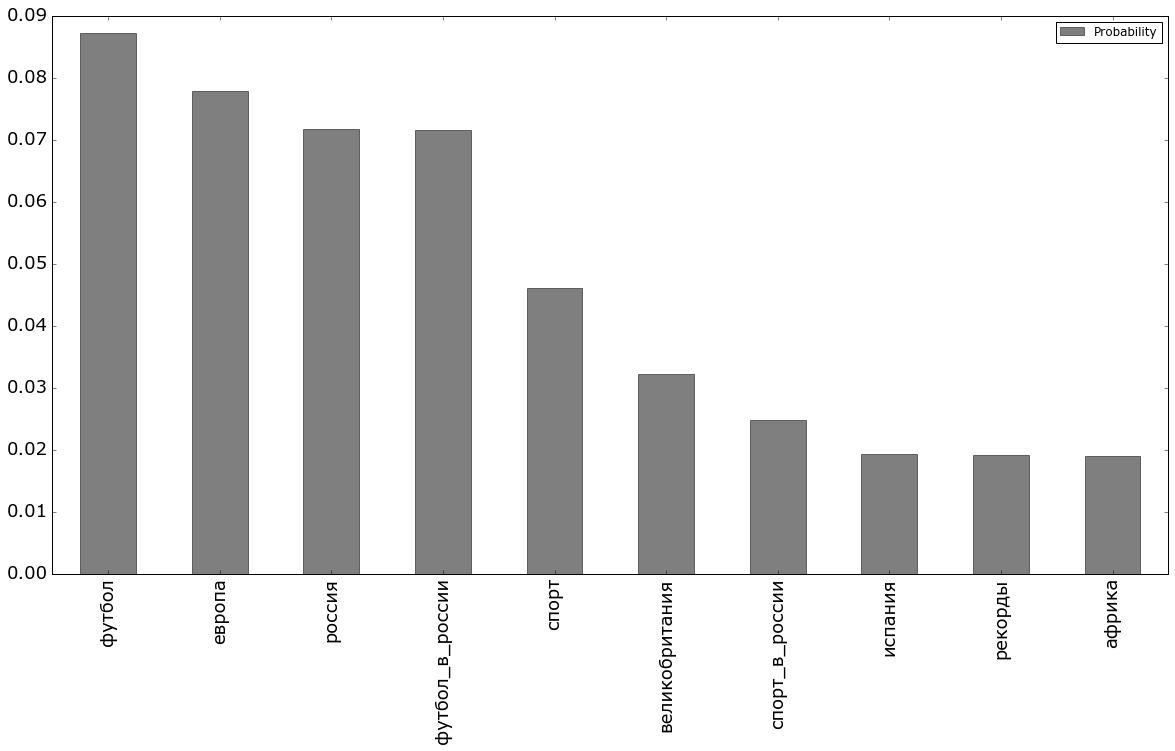

In [41]:
dfV2=dfV[0:10]
rcParams['font.family'] = 'verdana'
#xlabel(u"Категории")
dfV2.plot.bar(figsize=(20, 10), alpha=0.5, color='0', label=u'Кат', fontsize='18');

<h2>Регуляризация</h2>

In [ ]:
Pwt1=Pwt.copy()

In [ ]:
Pwt1[Pwt1<2]=0

In [ ]:
print Pwt1

In [ ]:
%%time
i1 = 0
Phi1 = np.arange(Pwt1.size, dtype=float).reshape(Pwt1.sum(axis=1).size, Pwt1[0].size)
for el4 in Pwt1.sum(axis=1):
    i2 = 0
    for el1 in Pwt1[i1]:
        Phi1[i1][i2]=float(el1)/Pwt1[i1].sum()
        i2 += 1
    i1 += 1
print (Phi1)

<h3>Результат регуляризации</h3>

In [ ]:
%%time
true1=0
false1=0
sum1=0
true2=[]
#test_doc_=random.randint(6000, 7000)

a = iter(list(range(bb)))
for i in a:
    numDStart=5750+i
    numDEnd=5750+i+1
    newD = vectorizerContent.transform(df4[numDStart:numDEnd]['category'].tolist()).toarray()
    #print (newD)
    j=0
    newDT=newD.transpose()
    predictMatrix = []
    for inNew in np.nditer(newD):
        if inNew > 0:
            #print (inNew)
            wordInDoc = float(pwdT[j].sum())
            k = 0
            for inCat in Pwt[j]:
                if inCat > 0:
                    wordInCat = float(pdtT[k].sum())
                    el_data= {}
                    el_data[selected_feature_names_Cat[k]] = Phi1[j][k]*(1-wordInCat/countDoc)*(1-wordInDoc/countDoc)*newDT[j]/newD.sum()
                    predictMatrix.append(dict(el_data))
                k += 1
        j += 1
    dfM = DataFrame(predictMatrix)
    del predictMatrix
    #print (dfM.head())
    
    list_test_cat = df4[numDStart:numDEnd]['category'].tolist()
    category2_test_=[]
    for line in list_test_cat:
        lines = line.strip().split(', ')
        lis=""
        for li in lines:
            cat = "_".join(li.lower().split(' '))
            category2_test_.append(cat)
    dfSumM=dfM.sum()
    
    n = 1
    m=0
    dfSumM.sort_values(ascending=False, kind='quicksort', na_position='last', inplace=True)
    for el in dfSumM.T.iteritems():
        sum1+=1
        if n < maxCat:
            if el[0] in category2_test_:
                if n==1:
                    true1+=1
                #print ("%s) BINGO %s = %f" % (n, el[0], el[1]))
                m += 1
            else:
                false1+=1
            
            n += 1
    #print (", ".join(category2_test_))
    true2.append(float((m)/len(category2_test_)))
    #print ("%s из %s" % (m, len(category2_test_)))
        
print ("True %s in %s" % (true1, bb))
print ("True %f in maxCat %s" % (sum(true2)/float(len(true2)), maxCat))
print ("False %f " % (float(false1)/sum1))

In [ ]:
%%time

newWord = vectorizerContent.transform([u"выборы призедента россии"]).toarray()
#print (newWord)
predictMatrixW = []
j=0
for inNew in np.nditer(newWord):
    if inNew > 0:
        wordInDoc = float(pwdT[j].sum())
        k = 0
        for inCat in Pwt[j]:
            if inCat > 0:
                wordInCat = float(pdtT[k].sum())
                el_data= {}
                el_data[selected_feature_names_Cat[k]] = Phi1[j][k]*(1-wordInCat/countDoc)*(1-wordInDoc/countDoc)
                predictMatrixW.append(dict(el_data))
            k +=1
    j+=1
dfMW = DataFrame(predictMatrixW)

#print (dfM.sum())
dfSumMW=dfMW.sum()
i =0
dfSumMW.sort_values(ascending=False, kind='quicksort', na_position='last', inplace=True)
for el in dfSumMW.T.iteritems():
    print ("%s) %s = %f" % (i, el[0], el[1]))
    #if i < 21:
    #    print ("%s) %s = %f" % (i, el[0], el[1]))
    i += 1